In [1]:
from ftplib import FTP
import os
import zipfile
#import gzip
#import tarfile
from pprint import pprint
import io
import pandas
import numpy as np
import time
from IPython.display import display, HTML
import geopandas
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from shapely.ops import unary_union
from shapely.geometry import Point, Polygon, box
from matplotlib.patches import FancyBboxPatch, BoxStyle
#import re
from matplotlib.path import Path

read_smaller_states = True

# #these_states_dict = {'FL': {}, 'MD': {}}
these_states_dict = {
                    'NJ': {},
            }

g = 0
scale = 20
map_buffer_ratio = .1
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "

equal_area_crs = 2163  # An equal area projection: https://epsg.io/2163
absolute_overlap_tol = 100    # tolerance for declaring areas overlapping, in sq meters
desired_pct_area_overlap = 0.5     # relative overlap to declare something a match

show_water = True
show_roads = False



water_area_tol = .5 * 1000 * 1000

#print('Target: each district should contain {0:,.0f} people!'.format(target))
print('ok')

ok


In [2]:
s = time.time()
script_dir = '/home/idies/workspace/Storage/raddick/jordanraddick.com/gerrymandering/'
census_script_dir = '/home/idies/workspace/Storage/raddick/census/'
basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/'
shapefile_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/2020/'
extras_dir = '/home/idies/workspace/Storage/raddick/census/extras/'

district_color_cycle = ['black', 'red', 'green', 'orange', 'cyan', 'yellow', 'pink', 'gray', 'lime', 'navajowhite', 'cornflowerblue', 'darkseagreen', 'thistle', 'tomato', 'silver', 'blueviolet', 'olive', 'peru', 'dodgerblue']
district_color_cycle += district_color_cycle
district_color_cycle += district_color_cycle

district_contrast_color_cycle = ['black', 'green', 'red', 'navy', 'black', 'purple', 'lime', 'black', 'red', 'red', 'black', 'red', 'black', 'black', 'white', 'yellow', 'yellow', 'yellow', 'yellow']
district_contrast_color_cycle += district_contrast_color_cycle
district_contrast_color_cycle += district_contrast_color_cycle

os.chdir(basedir)
e = time.time()
g += (e-s)
print('Now in directory: {0:}'.format(basedir))

Now in directory: /home/idies/workspace/Temporary/raddick/census_scratch/redistricting/2020/


In [3]:
print('setting up infrastructure to plot roads...')
# we may derive from matplotlib.patches.BoxStyle._Base class.
# You need to override transmute method in this case.
class shield(BoxStyle._Base):
    """
    A simple box.
    """

    def __init__(self, pad=0.3):
        """
        The arguments need to be floating numbers and need to have
        default values.

         *pad*
            amount of padding
        """

        self.pad = pad
        super().__init__()

    def transmute(self, x0, y0, width, height, mutation_size):
        """
        Given the location and size of the box, return the path of
        the box around it.

         - *x0*, *y0*, *width*, *height* : location and size of the box
         - *mutation_size* : a reference scale for the mutation.

        Often, the *mutation_size* is the font size of the text.
        You don't need to worry about the rotation as it is
        automatically taken care of.
        """

        # padding
        pad = mutation_size * self.pad

        # width and height with padding added.
        width, height = width + 2.*pad, \
                        height + 2.*pad,

        # boundary of the padded box
        x0, y0 = x0-pad, y0-pad,
        x1, y1 = x0+width, y0 + height

        cp = [(0.5*(x0+x1), (y0-2.*pad)), # bottom
              (x1, y0),  # right lower-mid
              (x1+pad, (y0+y1)/2.),  # far right mid
              (x1, y1+pad),  # top right corner
              ((x0+x1)/2,y1),  # dip from top
              (x0, y1+pad),  # top left corner
              (x0-pad, (y0+y1)/2.),    # far left mid
              (x0, y0),  # left lower-mid
              ((x0+x1)/2., (y0-2.*pad)),  # return to bottom
              ((x0+x1)/2., (y0-2.*pad))]
        
        
        com = [Path.MOVETO,  # start
               Path.CURVE4, # curve to right mid
               Path.LINETO,  # line to far right mid
               Path.LINETO, # line to top right corner
               Path.CURVE3,  # line to dip
               Path.LINETO,  # line to top left corner
               Path.CURVE4,   # curve to far left mid
               Path.LINETO,   # line to left lower-mid
               Path.LINETO,
               Path.CLOSEPOLY]

        path = Path(cp, com)

        return path

BoxStyle._style_list["shield"] = shield



def parse_road_name(thename):
    try:
        annotator = thisrow['FULLNAME'][re.search('\d',thisrow['FULLNAME']).start():]
    except AttributeError:
        try: 
            annotator = thisrow['FULLNAME'][re.search('Hwy',thisrow['FULLNAME']).end():]
        except AttributeError:
            annotator = thisrow['FULLNAME']
    return annotator


road_label_format = { 
    'I': { 'labelsize': 16, 'thecolor': 'yellow', 'thebbox': dict(boxstyle="shield", fc='blue', ec='orange') },     
    'U': { 'labelsize': 14, 'thecolor': 'black', 'thebbox': dict(boxstyle="shield", fc='white', ec='black') },
    'S': { 'labelsize': 12, 'thecolor': 'black', 'thebbox': dict(boxstyle="square,pad=0.25", fc='white', ec='black')},
    'C': { 'labelsize': 10, 'thecolor': 'black', 'thebbox': dict(boxstyle="sawtooth,pad=0.5", fc='white') }, 
    'M': { 'labelsize': 16, 'thecolor': 'black'},
    'O': { 'labelsize': 11, 'thecolor': 'yellow' }
}
print('Done!')



setting up infrastructure to plot roads...
Done!


In [4]:
s = time.time()
# print('Getting data from FTP...')

# ftp = FTP('ftp2.census.gov')
# ftp.login()
# print(ftp.getwelcome())

# ftp.cwd('programs-surveys/decennial/2020/data/01-Redistricting_File--PL_94-171/')
# for thisdir in [x for x in ftp.nlst() if (('.pdf' not in x) and ('.doc' not in x))]:
#     print('Retrieving {0:}...'.format(thisdir))
#     zipfiles = [x for x in ftp.nlst(thisdir)]
#     for thisfile in zipfiles:
#         with io.open(thisfile.split('/')[1].lower(), 'wb') as f:
#              ftp.retrbinary('RETR {0:}'.format(thisfile), f.write)
# ftp.quit()
# print('Done')

# os.listdir()
#os.getcwd()
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Retrieved files from Census FTP!')

Retrieved files from Census FTP!


In [5]:
s = time.time()
# for thisfile in os.listdir():
#     with zipfile.ZipFile(thisfile, 'r') as z:
#         print('Extracting {0:}...'.format(thisfile))
#         z.extractall()
# for thisfile in [x for x in os.listdir() if ('zip' in x)]:
#     os.remove(thisfile)
# print('Done!')
e = time.time()
g += (e-s)
#print('Done in {0:.1f} seconds!'.format(e-s))
print('Unzipped files!')

Unzipped files!


# How many districts per state?

In [6]:
state_seats_df = pandas.read_csv(script_dir+'state_seats.csv', index_col='state_name')

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
#state_codes_df.columns = [x.lower() for x in state_codes_df.columns]
state_codes_df = state_codes_df.set_index('STATE_NAME')

#bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# state_seats_df = state_seats_df.reset_index().merge(
#     geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']], how='left', 
#     left_on='state_name', right_on='NAME'
# )[['STATE', 'STUSAB', 'seats_old', 'seats_new']].set_index('STATE').sort_index()

# print('Found new numbers of districts for {0:,.0f} states!'.format(len(state_seats_df)))
#state_seats_df
#geo_df[geo_df['SUMLEV'] == 40][['STATE', 'STUSAB', 'NAME']]

state_seats_df = state_seats_df.join(state_codes_df).set_index('STATE').sort_index()

print('Got old and new numbers of districts for {0:,.0f} states in {1:.1f} seconds!'.format(len(state_seats_df), e-s))

for this_state in these_states_dict.keys():
    these_states_dict[this_state]['STATEFP'] = state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]    
    these_states_dict[this_state]['seats_old'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_old'].values[0]
    these_states_dict[this_state]['seats_new'] = state_seats_df[state_seats_df['STUSAB'] == this_state]['seats_new'].values[0]
#pprint(these_states_dict)
print('\n')
print('Got old and new numbers of districts for {0:,.0f} focus states in {1:.1f} seconds!'.format(len(these_states_dict), e-s))



looking up state names from numbers...
Got old and new numbers of districts for 50 states in 0.0 seconds!


Got old and new numbers of districts for 1 focus states in 0.0 seconds!


# Read summary levels

In [7]:
s = time.time()
print('setting up summary levels...')
sumlevel_df = pandas.read_excel(script_dir+'sumlevel.xlsx')
sumlevel_df = sumlevel_df.rename(columns={'sumlevel': 'SUMLEV'})
sumlevel_df.index.name = 'rownumber'
#sumlevel_df = sumlevel_df.set_index('SUMLEV')
e = time.time()
g += (e-s)
print('Read descriptions for {0:,.0f} summary levels in {1:.1f} seconds!'.format(len(sumlevel_df), e-s))
#sumlevel_df


setting up summary levels...
Read descriptions for 85 summary levels in 0.1 seconds!


# Read redistricting geo data

In [8]:
s = time.time()
print('reading redistricting geography data for all states...')
geofiles = []

allgeofiles = [x for x in os.listdir() if (('geo' in x) and (x[-3:] == '.pl') and (x[:2] not in ['dc', 'pr', 'mp', 'vi', 'as', 'gu']))]
for this_focus_state in list(these_states_dict.keys()):
    geofiles += [x for x in allgeofiles if x[0:2] == this_focus_state.lower()]
    #geofiles.append([x for x in geofiles if x[0:2] == this_focus_state.lower()])

geo_df = pandas.DataFrame()

for thisfile in geofiles:
    print('\treading {0:}...'.format(thisfile))
    geo_df_i = pandas.read_csv(thisfile, sep='|', header=None, low_memory=False, encoding='ISO-8859-1')#, encoding='utf-8')
    geo_df = pandas.concat((geo_df, geo_df_i), axis=0)
    
print('renaming columns...')
column_names = []
column_names += ['FILEID', 'STUSAB', 'SUMLEV', 'GEOVAR', 'GEOCOMP', 'CHARITER', 'CIFSN', 'LOGRECNO', 'GEOID']
column_names += ['GEOCODE', 'REGION', 'DIVISION', 'STATE', 'STATENS', 'COUNTY', 'COUNTYCC', 'COUNTYNS']
column_names += ['COUSUB', 'COUSUBCC', 'COUSUBNS']
column_names += ['SUBMCD', 'SUBMDCC', 'SUBMCDNS', 'ESTATE', 'ESTATECC', 'ESTATENS']
column_names += ['CONCIT', 'CONCITCC', 'CONCITNS', 'PLACE','PLACECC', 'PLACENS']
column_names += ['TRACT', 'BLKGRP', 'BLOCK']
column_names += ['AIANHH', 'AIANHHLI', 'AIANHHFP', 'AIANHHCC', 'AIANHHNS', 'AITS', 'AITSFP', 'AITSCC', 'AITSNS']
column_names += ['TTRACT', 'TBLKGRP', 'ANRC', 'ANRCCC', 'ARNCNS']
column_names += ['CBSA', 'MEMI', 'CSA', 'METDIV']
column_names += ['NECTA', 'NMEMI', 'CNECTA', 'NECTADIV']
column_names += ['CBSAPCI', 'NECTAPCI', 'UA', 'UATYPE', 'UR']
column_names += ['CD116', 'CD118', 'CD119', 'CD120', 'CD121']
column_names += ['SLDU18', 'SLDU22', 'SLDU24', 'SLDU26', 'SLDU28']
column_names += ['SLDL18', 'SLDL22', 'SLDL24', 'SLDL26', 'SLDL28']
column_names += ['VTD', 'VTDI', 'ZCTA', 'SDELM', 'SDSEC', 'SDUNI', 'PUMA']
column_names += ['AREALAND', 'AREAWATER', 'BASENAME', 'NAME', 'FUNCSTAT', 'GCUNI']
column_names += ['POP100', 'HU100']
column_names += ['INTPTLAT', 'INTPTLON', 'LSADC', 'PARTFLAG', 'UGA']

# for i in range(0, len(column_names)):    
#     if (np.isnan(pandas.to_numeric(column_names[i], errors='coerce'))):
#         geo_df = geo_df.rename(columns = {i: column_names[i]})
#     else:
#         geo_df = geo_df.rename(columns = {i: int(column_names[i])})

geo_df.columns = column_names

print('\tTotal columns: {0:.0f}'.format(len(geo_df.columns)))
print('\tNamed columns: {0:.0f}'.format(len(column_names)))

geo_df = geo_df.set_index('GEOID')


# print('finding stuff...')
# mycol = 'UGA'
# showcolumns = []
# showcolumns += ['SUMLEV', mycol]
#geo_df[geo_df[mycol].notnull()][showcolumns]
#print('done')

# geo_df.merge(sumlevel_df, how='left', on='SUMLEV')
# geo_df.set_index('SUMLEV')
# print('adding summary level descriptions...')
# geo_df = geo_df.reset_index().merge(sumlevel_df, how='left', on='SUMLEV').set_index('GEOID')
# geo_df = geo_df.rename(columns={'description': 'sumlev_description'})

#geo_df
e = time.time()
g += (e-s)
print('\n')
print('Read {0:,.0f} geographies in {1:.0f} minutes {2:.0f} seconds!'.format(len(geo_df), np.floor((e-s)/60), (e-s)%60))


reading redistricting geography data for all states...
	reading njgeo2020.pl...
renaming columns...
	Total columns: 97
	Named columns: 97


Read 259,704 geographies in 0 minutes 9 seconds!


In [9]:
s = time.time()
print('counting by summary level...')
count_df = pandas.DataFrame(data=None, columns=['sumlev_description', 'count', 'pop'], index=sumlevel_df['SUMLEV'].tolist())
count_df.index.name = 'SUMLEV'
count_df.loc[:, 'sumlev_description'] = sumlevel_df.set_index('SUMLEV')['description']
count_df.loc[:, 'count'] = geo_df.groupby('SUMLEV').size()
count_df.loc[:, 'pop'] = geo_df.groupby('SUMLEV')['POP100'].sum()
#count_df
nan_levels = count_df[count_df['count'].isnull()].index.tolist()

htmlstr = ''
htmlstr += '<table>'
htmlstr += '<tr>'
htmlstr += '<th>SUMLEVEL</th>'
for thiscol in count_df.columns.tolist():    
    htmlstr += '<th>{0:}</th>'.format(thiscol)
htmlstr += '</tr>'

for sumlev, thisrow in count_df.iterrows():
    #if ('remainder' not in thisrow['sumlev_description'].lower()):
    if (sumlev not in nan_levels):
        htmlstr += '<tr>'    
        htmlstr += '<td>{0:3d}</td><td>{1:}</td><td>{2:,.0f}</td><td>{3:,.0f}</td>'.format(sumlev, thisrow['sumlev_description'], thisrow['count'], thisrow['pop'])
        htmlstr += '</tr>'
htmlstr += '</table>'

# print('No data for these columns: {0:}'.format(nan_levels))
# display(HTML(htmlstr))

e = time.time()
g += (e-s)
print('\n')
print('Documented {0:,.0f} geographies in {1:.1f} seconds!'.format(len(count_df), e-s))



counting by summary level...


Documented 85 geographies in 0.1 seconds!


In [10]:
s = time.time()
print('Getting current Congressional District data...')
cd_df = geo_df[geo_df['SUMLEV'] == 500]
cd_df = cd_df[cd_df['CD116'] != 'ZZ']
cd_df.loc[:, 'CD116'] = pandas.to_numeric(cd_df['CD116'], errors='coerce')
cd_df.loc[cd_df['CD116'] == 0, 'CD116'] = 1

print('adding shapefiles...')
gdf = geopandas.read_file(shapefile_basedir+'CD/tl_2020_us_cd116.shp')
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '5001600US'+x)
gdf = gdf.set_index('GEOID')

cd_gdf = geopandas.GeoDataFrame(data=cd_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')
#cd_gdf

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} congressional districts to shapefiles in {1:.1f} seconds!'.format(len(cd_gdf), e-s))
#cd_gdf[['STATE', 'STUSAB']].drop_duplicates()
#cd_gdf.plot()
# print(cd_gdf.groupby('CD116')['POP100'].sum())
# print('\n')
# print(cd_gdf.groupby('STUSAB')['POP100'].sum())
# print('\n')
# print('{0:,.0f}'.format(cd_gdf['POP100'].sum()))


Getting current Congressional District data...
adding shapefiles...


Joined 12 congressional districts to shapefiles in 3.4 seconds!


In [11]:
print('getting tract data...')
s = time.time()
tract_df = geo_df[geo_df['SUMLEV'] == 140]
tract_df = tract_df.assign(census_tract = tract_df['TRACT'].apply(lambda x: x/100))
#tract_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

print('looking up state names from numbers...')
state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
tract_df = tract_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


print('looking up county names from numbers...')
county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
county_names_df = county_names_df.reset_index(drop=True)
tract_df = tract_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

print('adding empty column for new districts...')
tract_df = tract_df.assign(new_district = np.nan)

print('adding shapefiles...')
gdf = geopandas.GeoDataFrame()
for this_state in tract_df['STATE'].drop_duplicates().tolist():
    print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
    gdf_i = geopandas.read_file(shapefile_basedir+'TRACT/tl_2020_{0:02d}_tract.shp'.format(this_state))
    #print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
    gdf = pandas.concat((gdf, gdf_i), axis=0)
gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1400000US'+x)
gdf = gdf.set_index('GEOID')
tract_gdf = geopandas.GeoDataFrame(data=tract_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')


#state_codes_df
#tract_df = tract_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

e = time.time()
g += (e-s)
print('\n')
print('Joined {0:,.0f} tracts to shapefiles in {1:.1f} seconds!'.format(len(tract_gdf), e-s))



getting tract data...
looking up state names from numbers...
looking up county names from numbers...
adding empty column for new districts...
adding shapefiles...
	getting shapefiles for NJ...


Joined 2,181 tracts to shapefiles in 10.6 seconds!


In [12]:
# print('getting block group data...')
# s = time.time()
# bg_df = geo_df[geo_df['SUMLEV'] == 150]
# bg_df = bg_df.assign(census_tract = bg_df['TRACT'].apply(lambda x: x/100))
# #bg_df[['SUMLEV', 'STATE', 'STUSAB', 'COUNTY', 'census_tract', 'BLKGRP', 'NAME']].sample(3)

# print('looking up state names from numbers...')
# state_codes_df = pandas.read_csv(extras_dir+'statecodes.csv')
# bg_df = bg_df.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')


# print('looking up county names from numbers...')
# county_names_df = pandas.read_excel(extras_dir+'all-geocodes-v2019.xlsx', header=4)
# county_names_df = county_names_df[county_names_df['Summary Level'] == 50]
# county_names_df = county_names_df.rename(columns={'State Code (FIPS)': 'STATE', 'County Code (FIPS)': 'COUNTY', 'Area Name (including legal/statistical area description)': 'COUNTY_NAME' })
# county_names_df = county_names_df.reset_index(drop=True)
# bg_df = bg_df.reset_index().merge(county_names_df[['STATE', 'COUNTY', 'COUNTY_NAME']], how='left', on=['STATE', 'COUNTY']).set_index('GEOID')

# print('adding empty column for new districts...')
# bg_df = bg_df.assign(new_district = np.nan)

# print('adding shapefiles...')
# gdf = geopandas.GeoDataFrame()
# for this_state in bg_df['STATE'].drop_duplicates().tolist():
#     print('\tgetting shapefiles for {0:}...'.format(state_codes_df[state_codes_df['STATE'] == this_state]['STUSAB'].values[0]))
#     gdf_i = geopandas.read_file(shapefile_basedir+'BG/tl_2020_{0:02d}_bg.shp'.format(this_state))
#     print('\t\t{0:} CRS = {1:}'.format(this_state, gdf_i.crs))
#     gdf = pandas.concat((gdf, gdf_i), axis=0)
# gdf.loc[:, 'GEOID'] = gdf['GEOID'].apply(lambda x: '1500000US'+x)
# gdf = gdf.set_index('GEOID')
# bg_gdf = geopandas.GeoDataFrame(data=bg_df.join(gdf.geometry), crs=gdf.crs, geometry='geometry')




# #state_codes_df
# #bg_df = bg_gdf.reset_index().merge(state_codes_df[['STATE', 'STATE_NAME']], how='left', on='STATE').set_index('GEOID')

# e = time.time()
# g += (e-s)
# print('\n')
# print('Joined {0:,.0f} block groups to shapefiles in {1:.1f} seconds!'.format(len(bg_gdf), e-s))




In [13]:
s = time.time()
this_state = 'NJ'

state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

print('getting states...')
state_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_state.shp')
state_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(state_gdf['INTPTLON'])
state_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(state_gdf['INTPTLAT'])
state_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_gdf['STATEFP'], errors='coerce')
#state_gdf = state_gdf[state_gdf['STATEFP'].isin(state_numbers_include_list)]
state_gdf = state_gdf.set_index('GEOID')

print('getting counties...')
county_gdf = geopandas.read_file(shapefile_basedir+'tl_2020_us_county.shp')
county_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(county_gdf['STATEFP'], errors='coerce')
county_gdf.loc[:, 'COUNTYNS'] = pandas.to_numeric(county_gdf['COUNTYNS'], errors='coerce')
county_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(county_gdf['INTPTLON'])
county_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(county_gdf['INTPTLAT'])
#county_gdf = county_gdf[county_gdf['STATEFP'].isin(state_numbers_include_list)]
county_gdf = county_gdf.set_index('GEOID')

e = time.time()
g += (e-s)
print('Got {0:,.0f} states and {1:,.0f} counties in {2:.1f} seconds!'.format(len(state_gdf), len(county_gdf), e-s))
print('\n')


if (show_water):
    print('getting water areas...')

    waterfiles = [shapefile_basedir+'AREAWATER/'+x for x in os.listdir(shapefile_basedir+'AREAWATER/') if ((x[-4:] == '.shp') )]
    state_numbers_include_list = cd_gdf['STATE'].drop_duplicates().tolist()
    state_numbers_include_list = ['{0:02d}'.format(x) for x in state_numbers_include_list]

    waterfiles = [x for x in waterfiles if x[89:91] in state_numbers_include_list]

    water_gdf = geopandas.GeoDataFrame()

    for i in range(0, len(waterfiles)):
        if (np.mod(i, 10) == 0):
            print('\treading water file {0:,.0f} of {1:,.0f}...'.format(i, len(waterfiles)))
        water_gdf_i = geopandas.read_file(waterfiles[i])
        water_gdf_i = water_gdf_i[water_gdf_i['AWATER'] >= water_area_tol]
        water_gdf_i = water_gdf_i.assign(STUSAB = state_codes_df[state_codes_df['STATE'] == int(waterfiles[i][89:91])]['STUSAB'].values[0])
        water_gdf = pandas.concat((water_gdf, water_gdf_i), axis=0)
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')
    water_gdf = water_gdf.set_index('HYDROID')
    
    e = time.time()
    g += (e-s)

    print('Got {0:,.0f} water areas in {1:.0f} minutes {2:.1f} seconds!'.format(len(water_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


s = time.time()
print('getting CBSAs (metro areas)...')
cbsa_gdf = geopandas.read_file(shapefile_basedir+'CBSA/tl_2020_us_cbsa.shp')
cbsa_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(cbsa_gdf['INTPTLON'])
cbsa_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(cbsa_gdf['INTPTLAT'])
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'])
cbsa_gdf = cbsa_gdf.set_index('GEOID')

print('\tFinding populations of CBSAs...')
cbsa_gdf = cbsa_gdf.assign(POP100 = np.nan)
for ix, thisrow in cbsa_gdf.sort_values(by='NAME').iterrows():
    cbsa_gdf.loc[ix, 'POP100'] = tract_gdf[(tract_gdf['COUNTYNS'].isin(county_gdf[county_gdf.geometry.within(thisrow.geometry)]['COUNTYNS'].tolist()))]['POP100'].sum()
    if (this_state in thisrow['NAME']):
        print('\t\t{0:} (n = {1:,.0f})...'.format(thisrow['NAME'], cbsa_gdf.loc[ix]['POP100']))
cbsa_gdf.loc[cbsa_gdf[cbsa_gdf['POP100'] == 0].index.tolist(), 'POP100'] = np.nan

e = time.time()
g += (e-s)
print('Got {0:,.0f} CBSAs in {1:.1f} seconds!'.format(len(cbsa_gdf), e-s))
print('\n')
s = time.time()
print('getting places...')
placefiles = [shapefile_basedir+'PLACE/'+x for x in os.listdir(shapefile_basedir+'PLACE/') if ((x[-4:] == '.shp'))]
placefiles = [x for x in placefiles if x[85:87] in state_numbers_include_list]

place_gdf = geopandas.GeoDataFrame()

for i in range(0, len(placefiles)):
    if (np.mod(i, 5) == 0):
        print('\treading place file {0:,.0f} of {1:,.0f}...'.format(i, len(placefiles)))
    place_gdf_i = geopandas.read_file(placefiles[i])
    place_gdf = pandas.concat((place_gdf, place_gdf_i), axis=0)
place_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(place_gdf['STATEFP'])
place_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(place_gdf['INTPTLON'])
place_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(place_gdf['INTPTLAT'])

place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '1600000US'+x)
place_gdf = place_gdf.set_index('GEOID')
e = time.time()
g += (e-s)
print('Got {0:,.0f} places in {1:.1f} seconds!'.format(len(place_gdf), e-s))
print('\n')

if (show_roads):
    print('getting roads...')
    roads_gdf = geopandas.GeoDataFrame()
    roads_file_list = [shapefile_basedir+'ROADS/'+x for x in os.listdir(shapefile_basedir+'ROADS/') if ((x[-4:] == '.shp') and (x[8:10] in state_numbers_include_list))]# and ('_{0:02d}'.format()))]# and ('tl_2018_{0:02d}'.format(this_state_number) in x))]
    for i in range(0, len(roads_file_list)):
        if ((np.mod(i,1) == 0) | (i == len(roads_file_list)-1)):
            print('\tReading road file {0:,.0f} of {1:,.0f}...'.format(i+1, len(roads_file_list)))
        roads_gdf_i = geopandas.read_file(roads_file_list[i])    
        roads_gdf = pandas.concat((roads_gdf, roads_gdf_i), axis=0, sort=False)
    roads_gdf = roads_gdf.set_index('LINEARID')
    e = time.time()
    g += (e-s)
    print('Got {0:,.0f} roads in {1:.0f} minutes {2:.1f} seconds!'.format(len(roads_gdf), np.floor((e-s)/60), (e-s)%60))
    print('\n')


print('Done!')


cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x)][['NAME', 'POP100']].sort_values(by='POP100', ascending=False)


getting states...
getting counties...
Got 56 states and 3,234 counties in 6.1 seconds!


getting water areas...
	reading water file 0 of 21...
	reading water file 10 of 21...
	reading water file 20 of 21...
Got 252 water areas in 0 minutes 11.5 seconds!


getting CBSAs (metro areas)...
	Finding populations of CBSAs...
		Allentown-Bethlehem-Easton, PA-NJ (n = 109,632)...
		Atlantic City-Hammonton, NJ (n = 274,534)...
		New York-Newark-Jersey City, NY-NJ-PA (n = 6,915,597)...
		Ocean City, NJ (n = 95,263)...
		Philadelphia-Camden-Wilmington, PA-NJ-DE-MD (n = 1,352,476)...
		Trenton-Princeton, NJ (n = 387,340)...
		Vineland-Bridgeton, NJ (n = 154,152)...
Got 939 CBSAs in 62.0 seconds!


getting places...
	reading place file 0 of 1...
Got 701 places in 0.4 seconds!


Done!


,NAME,POP100
GEOID,,
35620,"New York-Newark-Jersey City, NY-NJ-PA",6915597.0
37980,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",1352476.0
45940,"Trenton-Princeton, NJ",387340.0
12100,"Atlantic City-Hammonton, NJ",274534.0
47220,"Vineland-Bridgeton, NJ",154152.0
10900,"Allentown-Bethlehem-Easton, PA-NJ",109632.0
36140,"Ocean City, NJ",95263.0


In [14]:

# s = time.time()
# print('setting up insets...')
# insets = {}

# insets['se'] = {}
# insets['se']['how'] = 'districts'
# insets['se']['bounds'] = [-80.48, 25.54, -80, 26.84]
# insets['se']['axes_position'] = [0.3, 0.01]
# insets['se']['axes_rel_size'] = .255
# insets['se']['districts'] = [21,22,23,24,27]
# insets['se']['partial_districts'] = [18,20,25,26]
# insets['se']['counties'] = ['Palm Beach County', 'Broward County', 'Miami-Dade County']
# insets['se']['title'] = 'Southeast Florida'
# insets['se']['titlesize'] = 22
# insets['se']['borderwidth'] = 3

# insets['tpa'] = {}
# insets['tpa']['how'] = 'districts'
# #insets['tpa']['bounds'] = [-82.85, 27.6, -82, 28.2]
# insets['tpa']['bounds'] = [-82.9, 27.6, -82.18, 28.2]
# insets['tpa']['axes_position'] = [0.03, 0.015]
# insets['tpa']['axes_rel_size'] = 0.255
# insets['tpa']['districts'] = [13,14]
# insets['tpa']['partial_districts'] = [12, 15, 16]
# insets['tpa']['counties'] = ['Hillsborough County', 'Pinellas County']
# insets['tpa']['title'] = 'Tampa Bay'
# insets['tpa']['titlesize'] = 22
# insets['tpa']['borderwidth'] = 3

# insets['orl'] = {}
# insets['orl']['how'] = 'counties'
# insets['orl']['bounds'] = [-81.68, 28.33, -80.82, 28.88]

# insets['orl']['axes_position'] = [0.03, 0.26]
# insets['orl']['axes_rel_size'] = 0.255
# insets['orl']['districts'] = [7,10]
# insets['orl']['partial_districts'] = [6,8,9,11,15]
# insets['orl']['counties'] = ['Orange County', 'Seminole County']
# insets['orl']['title'] = 'Orlando'
# insets['orl']['titlesize'] = 22
# insets['orl']['borderwidth'] = 3

# insets['jax'] = {}
# insets['jax']['how'] = 'counties'
# insets['jax']['axes_position'] = [0.84, 0.87]
# insets['jax']['axes_rel_size'] = 0.15
# insets['jax']['districts'] = [4,5]
# insets['jax']['partial_districts'] = [3]
# insets['jax']['counties'] = ['Duval County']
# insets['jax']['title'] = 'Jacksonville'
# insets['jax']['titlesize'] = 22
# insets['jax']['borderwidth'] = 3

# insets['tally'] = {}
# insets['tally']['how'] = 'places'
# insets['tally']['axes_position'] = [0.84, 0.69]
# insets['tally']['axes_rel_size'] = 0.15
# insets['tally']['districts'] = [2,5]
# insets['tally']['partial_districts'] = []
# insets['tally']['counties'] = ['Leon County']
# insets['tally']['places'] = ['Tallahassee']
# insets['tally']['title'] = 'Tallahassee'
# insets['tally']['titlesize'] = 22
# insets['tally']['borderwidth'] = 3


# for inset_name, inset in insets.items():
#     print(inset_name)
    
#     if ('bounds' in inset.keys()):
#         inset['aspect_ratio'] = (inset['bounds'][2] - inset['bounds'][0]) / (inset['bounds'][3] - inset['bounds'][1])
#     else:
#         if (inset['how'] == 'districts'):
#             thegeo = unary_union(cd_gdf[cd_gdf['CD116'].isin(inset['districts'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'counties'):
#             thegeo = unary_union(tract_gdf[tract_gdf['COUNTY_NAME'].isin(inset['counties'])].geometry.tolist()).bounds
#         elif (inset['how'] == 'places'):
#             thegeo = unary_union(place_gdf[place_gdf['NAME'].isin(inset['places'])].geometry.tolist()).bounds
#         xlims = [thegeo[0], thegeo[2]]
#         ylims = [thegeo[1], thegeo[3]]        
#         xspan = xlims[1] - xlims[0]
#         yspan = ylims[1] - ylims[0]
#         inset['aspect_ratio'] = xspan / yspan
#         xlims[0] = xlims[0] - (map_buffer_ratio * xspan)
#         ylims[0] = ylims[0] - (map_buffer_ratio * yspan)
#         xlims[1] = xlims[1] + (map_buffer_ratio * xspan)
#         ylims[1] = ylims[1] + (map_buffer_ratio * yspan)    
#         inset['bounds'] = [xlims[0], ylims[0], xlims[1], ylims[1]]
#         print(inset['bounds'])
    
#     inset['box_gdf'] = geopandas.GeoDataFrame(data=[[
#         box(
#             inset['bounds'][0], 
#             inset['bounds'][1], 
#             inset['bounds'][2], 
#             inset['bounds'][3]
#         )]], columns=['geometry'], crs=cd_gdf.crs, geometry='geometry')    
#     inset['axes_size'] = [inset['axes_rel_size'], inset['axes_rel_size'] / inset['aspect_ratio']]
# #    print(inset['axes_size'])

# all_inset_districts = []
# for inset in insets.values():
#     all_inset_districts += inset['districts']
# main_map_districts = [x for x in list(range(1, these_states_dict[list(these_states_dict.keys())[0]]['seats_old']+1)) if x not in all_inset_districts]

# main_map_districts += [x for x in insets['jax']['districts']]
# main_map_districts += [x for x in insets['tally']['districts']]
# main_map_districts = sorted(main_map_districts)

# #print(main_map_districts)
# e = time.time()
# g += (e-s)
# print('Done!')
# #main_map_districts


main map...
	reprojecting...
	plotting...
		Plotting NJ...
	plotting census tracts...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...
Done plotting in 27 seconds!


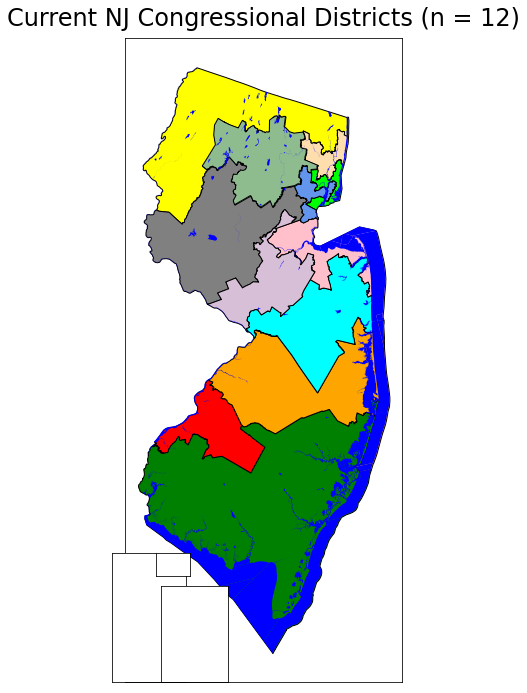

In [15]:
s = time.time()
# main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "
# alaska_crs = "epsg:3338"
# hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = True

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].tolist():#.sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    cdlist = cd_gdf[cd_gdf['STUSAB'] == this_state]['CD116'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(cdlist)+1):
        cd_gdf[
            (cd_gdf['STUSAB'] == this_state) 
            & (cd_gdf['CD116'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
#         annotator = i
#         this_district_geo = unary_union(cd_gdf[(cd_gdf['STUSAB'] == this_state) & (cd_gdf['CD116'] == i)].to_crs(main_map_crs).geometry.tolist())
#         centerpoint = (this_district_geo.centroid.x, this_district_geo.centroid.y)
#         ax.annotate(annotator, centerpoint, 
#                     color='black', backgroundcolor='white', ha='center', va='center', fontsize=20)

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
# #ax.legend(handles=legend_list, fontsize=10)


if (len(list(these_states_dict.keys())) == 1):
    ax.set_title('Current {0:} Congressional Districts (n = {1:.0f})'.format(
        list(these_states_dict.keys())[0], 
        these_states_dict[list(these_states_dict.keys())[0]]['seats_old']
    ), fontsize=24, y=1.01)
else:
    ax.set_title('Current Congressional Districts', fontsize=24, y=1.01)

# # # # ax.tick_params(axis='both', labelsize=20)

# # # # # print('saving figure...')
# # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # #plt.show()
# # e = time.time()
# # g += (e-s)
# # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'AK']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'AK') & (cd_gdf['CD116'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
cdlist = cd_gdf[cd_gdf['STUSAB'] == 'HI']['CD116'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        cd_gdf[(cd_gdf['STUSAB'] == 'HI') & (cd_gdf['CD116'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

for thisax in [ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

# print('saving figure...')
# fig.savefig(script_dir+'all-districts-orig.jpg', format='jpg', dpi=300, bbox_inches='tight')
#plt.show()
e = time.time()
g += (e-s)
print('Done plotting in {0:,.0f} seconds!'.format(e-s))

# How many districts in each state?

In [16]:
for this_state_name, this_state in these_states_dict.items():
    if (this_state['seats_new'] == 1):
        these_states_dict[this_state_name]['target'] = -1
    else:
        these_states_dict[this_state_name]['target'] = cd_gdf[cd_gdf['STUSAB'] == this_state_name]['POP100'].sum() / this_state['seats_new']
    
    
these_states_dict
#water_gdf.head(1).T

{'NJ': {'STATEFP': 34,
  'seats_old': 12,
  'seats_new': 12,
  'target': 774082.8333333334}}

# NEW JERSEY

In [17]:
s = time.time()

this_state = 'NJ'
examine_duplicates = True

nDistricts = these_states_dict[this_state]['seats_new']
state_target = these_states_dict[this_state]['target']

#print('getting from backup...')
tract_gdf.loc[tract_gdf['STUSAB'] == this_state, 'new_district'] = np.nan

county_mapper_df = pandas.DataFrame(data=[ 

['Sussex County',5],
    
['Warren County',7],
    ['Hunterdon County',7],
    
    
['Mercer County',3],


# ['Camden County',1],
#     ['Gloucester County',1],
    
], columns=['COUNTY_NAME', 'new_district_by_county'])
county_mapper_df = county_mapper_df.assign(STUSAB = this_state)

place_mapper_df = pandas.DataFrame(data=[
['West New York',8], 
    ['Edgewater',8], 
    ['Bayonne',8], 
    ['Jersey City',8], 
    ['Hoboken',8], 
    ['Union City',8], 
    ['Guttenberg',8], 
    ['Fort Lee',8],
    ['Fairview',8], 
    ['Cliffside Park',8], 
    ['Palisades Park',8],
    ['Secaucus',8],

    
['Newark',10],
    ['East Newark',10],
    ['Kearny',10],
    ['Harrison',10],
    ['Elizabeth',10],
    ['Watsessing',10], 
    ['Ampere North',10], 
    ['East Orange',10], 
    ['North Arlington',10],
    ['Rutherford',10],
    ['East Rutherford',10],
    
    
['Englewood Cliffs',9], 
    ['Englewood',9], 
    ['Leonia',9], 
    ['Ridgefield',9], 
    ['Carlstadt',9], 
    ['Moonachie',9], 
    ['Wood-Ridge',9], 
    ['Little Ferry',9], 
    ['Ridgefield Park',9], 
    ['Bogota',9], 
    ['Hasbrouck Heights',9], 
    ['Teterboro',9], 
    ['Hackensack',9],
    ['New Milford',9], 
    ['Bergenfield',9], 
    ['River Edge',9], 
    ['Lodi',9], 
    ['Garfield',9], 
    ['Maywood',9], 
    ['Elmwood Park',9],
    ['Paramus',9],
    ['Fair Lawn',9],
    ['Passaic',9], 
    ['Clifton',9], 
    ['Paterson',9],
    ['Wallington',9], 

    
['Woodland Park',11], 
    ['Prospect Park',11], 
    ['Hawthorne',11],
    ['Montclair State University',11], 
    ['William Paterson University of New Jersey',11], 
    ['Great Notch',11], 
    ['Totowa',11], 
    ['Preakness',11],
    ['North Haledon',11], 
    ['Haledon',11], 
    ['Packanack Lake',11], 
    ['Pines Lake',11], 
    ['Union',11],
    ['Vauxhall',11],
    ['Kenilworth',11],
    ['Roselle',11],
    ['Roselle Park',11],
    ['Mountainside',11],
    ['Summit',11],
    ['Westfield',11],
    ['Garwood',11],
    ['Cranford',11],
    ['Linden',11],
    
    
['Pompton Plains',5], 
    ['Kinnelon',5], 
    ['Butler',5], 
    ['Riverdale',5], 
    ['Oak Ridge',5], 
    ['Lincoln Park',5], 
    ['Towaco',5],
    ['Lake Telemark',5], 
    ['Hibernia',5], 
    ['White Meadow Lake',5], 
    ['Rockaway',5], 
    ['Mount Hope',5], 
    ['Boonton',5], 
    ['Lake Hiawatha', 5],
    ['Mountain Lakes',5], 
    ['Lake Hopatcong',5],
    ['Pine Brook',5], 
    ['Whippany',5], 
    ['Troy Hills',5], 
    ['Rainbow Lakes',5],
    ['Parsippany',5],     
    ['Mount Tabor',5],     
    ['Cedar Knolls',5], 
    ['Morris Plains',5],     


    
['Watchung',6],
    ['North Plainfield',6],
    ['Carteret',6],
    ['Port Reading',6],
    ['Avenel',6],
    ['Colonia',6],
     ['Iselin',6],
    ['Sewaren',6],
    ['Woodbridge',6],
    ['Menlo Park Terrace',6],
    ['Fords',6],
    ['Hopelawn',6],
    ['Perth Amboy',6],
    ['Keasbey',6],
    ['Metuchen',6],
    ['South Plainfield',6],
    ['Dunellen',6],
    ['Middlesex',6],
    ['South Amboy',6],
    ['Sayreville',6],
    ['New Brunswick',6], 
    ['Highland Park',6], 
    ['Laurence Harbor',6],
    ['South River',6], 
    ['Madison Park',6], 
    
    
['Kendall Park',7],
    ['Heathcote',7],
    

['Franklin Park',12], 
    ['Six Mile Run',12], 
    ['Voorhees',12], 
    ['Clyde',12], 
    ['Somerset',12], 
    ['East Franklin',12],    
    ['Strathmore',12], 
    ['Matawan',12], 
    ['Union Beach',12], 
    ['Keansburg',12], 
    ['Cliffwood Beach',12], 
    ['Port Monmouth',12], 
    ['North Middletown',12], 
    ['Morganville',12],
    ['Leonardo',12],
    ['Atlantic Highlands',12],
    ['Highlands',12],
    ['Belford',12],
    ['Navesink',12],
    ['Lincroft',12], 
    ['Fair Haven',12], 
    ['Sea Bright',12], 
    ['Red Bank',12], 
    ['Little Silver',12], 
    ['Monmouth Beach',12], 
    ['Shrewsbury',12],
    ['Rumson',12],
    ['Oceanport',12],
    ['Long Branch',12],
    ['West Long Branch',12],
    ['Eatontown',12],
    ['Robertsville',12],
    ['Freehold',12],
    ['East Freehold',12],
    ['West Freehold',12],
    ['Yorketown',12],
    ['Oakhurst',12], 
    ['Deal',12], 
    ['Wanamassa',12], 
    ['Allenhurst',12], 
    ['Loch Arbour',12], 
    ['Asbury Park',12], 
    ['Ocean Grove',12],
    ['Bradley Beach',12],
    ['Interlaken',12], 
    
    
['Camden',1], 
    ['Woodlynne',1], 
    ['Collingswood',1], 
    ['Merchantville',1], 
    ['Oaklyn',1], 
    ['Gloucester City',1], 
    ['Audubon',1], 
    ['Audubon Park',1],
    ['Westmont',1], 
    ['Mount Ephraim',1], 
    ['Brooklawn',1], 
    ['Bellmawr',1], 
    ['Golden Triangle',1], 
    ['Cherry Hill Mall',1], 
    ['Ellisburg',1], 
    ['Haddonfield',1],
    ['Haddon Heights',1], 
    ['Barrington',1], 
    ['Lawnside',1], 
    ['Magnolia',1], 
    ['Ashland',1], 
    ['Barclay',1], 
    ['Kingston Estates',1],
    ['Runnemede',1], 
    ['Echelon',1], 
    ['Glendora',1], 
    ['Somerdale',1], 
    ['Hi-Nella',1], 
    ['Stratford',1], 
    ['Laurel Springs',1], 
    ['Springdale',1], 
    ['Greentree',1],
    ['Gibbsboro',1], 
    ['Clementon',1], 
    ['Pine Valley',1],
    ['Pine Hill',1], 
    ['Lindenwold',1], 
    ['Berlin',1], 
    ['West Berlin',1], 
    ['Blackwood',1], 
    ['Grenloch',1], 
    ['Sicklerville',1],
    ['Westville',1], 
    ['Woodbury',1], 
    ['Woodbury Heights',1], 
    ['Thorofare',1], 
    ['National Park',1], 
    ['Oak Valley',1], 
    ['Wenonah',1], 
    ['Sewell',1],
    ['Marlton',1], 
    ['Ramblewood',1], 
    ['Moorestown-Lenola',1], 
    ['Palmyra',1], 
    ['Riverton',1],
    ['Turnersville',1], 
    ['Paulsboro',1], 
    ['Pitman',1], 
    
], columns=['NAME', 'new_district_by_place'])


#print('Assigning districts by county...')
tract_gdf.loc[tract_gdf[tract_gdf['STUSAB'] == this_state].index, 'new_district'] = tract_gdf[tract_gdf['STUSAB'] == this_state].reset_index().merge(county_mapper_df, how='left', on=['STUSAB','COUNTY_NAME']).set_index('GEOID')['new_district_by_county']


print('Assigning districts by place...')
place_mapper_gdf = geopandas.GeoDataFrame(place_mapper_df.merge(place_gdf.reset_index(), how='left', on='NAME')[['GEOID', 'NAME', 'new_district_by_place', 'geometry']].set_index('GEOID'))


print('Accounting for known duplicate places...')
keepers = {}

 
keepers['Fairview'] = {'GEOID': '1600000US3422560', 'description': 'overlaps 3 tracts containing 15,025 people'}


for k,v in keepers.items():
    print('\t{0:}: Keeping GEOID = {1:}: {2:}!'.format(k, v['GEOID'], v['description']))
    place_mapper_gdf = place_mapper_gdf.drop(place_mapper_gdf[(place_mapper_gdf['NAME'] == k) & (place_mapper_gdf.index != v['GEOID'])].index, axis=0)

print('\n')
print('checking for additional duplicate nanes...')
duplicate_place_names = place_mapper_gdf[place_mapper_gdf['NAME'].duplicated()]['NAME'].tolist()
for this_place in duplicate_place_names:
    print('Examining {0:}...'.format(this_place))
    
    for ix, thisrow in place_gdf[
        (place_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
        & (place_gdf['NAME'] == this_place)
    ].to_crs(equal_area_crs).iterrows():
        included_tracts = []
        place_area = thisrow.geometry.area
        print('\t{0:} (GEOID = {1:}), place area = {2:,.2f} km^2...'.format(thisrow['NAMELSAD'], ix, place_area / 1000000))
        
        for jx, thatrow in county_gdf[
            (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
            & (county_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
        ].to_crs(equal_area_crs).iterrows():
            if (thatrow.geometry.intersection(thisrow.geometry).area >= absolute_overlap_tol):
                print('\t\t...overlaps with {0:} by {1:,.2f} km^2...'.format(thatrow['NAMELSAD'], thatrow.geometry.intersection(thisrow.geometry).area / 1000000))
                for kx, otherrow in tract_gdf[
                    #(tract_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
                    (tract_gdf['STUSAB'] == this_state)
                    & (tract_gdf['COUNTY_NAME'] == thatrow['NAMELSAD'])
                    & (tract_gdf.to_crs(equal_area_crs).geometry.apply(lambda x: x.intersects(thisrow.geometry)))
                ].to_crs(equal_area_crs).iterrows():
                    tract_area = otherrow.geometry.area
                    overlap_area = otherrow.geometry.intersection(thisrow.geometry).area
                    pct_overlap = overlap_area / tract_area
                    if (pct_overlap >= desired_pct_area_overlap):
                        print('\t\t\tOverlaps {0:.1%} of census tract {1:}...'.format(pct_overlap, otherrow['census_tract']))
                        included_tracts.append(kx)
        print('\t{0:} (GEOID = {1:}) overlaps {2:.0f} tracts containing {3:,.0f} people!'.format(thisrow['NAME'], ix, len(tract_gdf[tract_gdf.index.isin(included_tracts)]), tract_gdf[tract_gdf.index.isin(included_tracts)]['POP100'].sum()))
        print('-------------------------------------')
        print('\n')
        
print('\n')
for i in range(1, nDistricts+1):
    print('Looking for tracts related to places in District {0:.0f}...'.format(i))
    tracts_here = []
    this_district_places_geo = unary_union(place_mapper_gdf[place_mapper_gdf['new_district_by_place'] == i].geometry.tolist())
    tracts_within = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.within(this_district_places_geo))
    ].index.tolist()
    if (len(tracts_within) > 0):
        print('\tTracts within District {0:.0f}: {1:,.0f}...'.format(i, len(tracts_within)))
    tracts_here += tracts_within
    
    intersecting_tracts = tract_gdf[
        (tract_gdf['STUSAB'] == this_state) 
        & (tract_gdf['new_district'].isnull()) 
        & (tract_gdf.geometry.intersects(this_district_places_geo))
        & ~(tract_gdf.index.isin(tracts_within))
    ].index.tolist()
    if (len(intersecting_tracts) > 0):
        print('\tTracts intersecting (but not within) District {0:.0f}: {1:,.0f}...'.format(i, len(intersecting_tracts)))
    
    cnt = 0
    for ix, thisrow in tract_gdf[tract_gdf.index.isin(intersecting_tracts)].iterrows():
        cnt += 1
        if (np.mod(cnt,50) == 1):            
            print('\t\tExamining tract {0:,.0f} of {1:,.0f}...'.format(cnt, len(intersecting_tracts)))
        tract_area_sq_deg = thisrow.geometry.area
        overlap_area_sq_deg = thisrow.geometry.intersection(this_district_places_geo).area
        overlap_pct = overlap_area_sq_deg / tract_area_sq_deg
        if (overlap_pct >= desired_pct_area_overlap):
            tracts_here.append(ix)
            #print('\t\t\tTract {0:}-{1:} overlaps by {2:.1%}...'.format(thisrow['COUNTY_NAME'].split(" County")[0], thisrow['census_tract'], overlap_pct))

    tract_gdf.loc[tracts_here, 'new_district'] = i

print('Assigning districts by tract number...')
tract_gdf.loc[['1400000US34017017900', '1400000US34017018000', '1400000US34017018100', '1400000US34017018200'], 'new_district'] = 8    # E of Union City
tract_gdf.loc[['1400000US34017014101', '1400000US34017014102', '1400000US34017014200', '1400000US34017014300', '1400000US34017014401', '1400000US34017014402', '1400000US34017014501', '1400000US34017014502', '1400000US34017014000'], 'new_district'] = 8    # N of Guttenberg
tract_gdf.loc[['1400000US34017014600', '1400000US34017014700', '1400000US34017014801', '1400000US34017014802', '1400000US34017014900'], 'new_district'] = 8    # Between West New York and Secaucus


tract_gdf.loc[['1400000US34013014700', '1400000US34013015500', '1400000US34013015800'], 'new_district'] = 10    # Silver Lake
tract_gdf.loc[['1400000US34013011900', '1400000US34013012000', '1400000US34013012100', '1400000US34013012200', '1400000US34013012300', '1400000US34013012400', '1400000US34013012500', '1400000US34013012600'], 'new_district'] = 10    # SW of Newark
tract_gdf.loc[['1400000US34013012700', '1400000US34013012800', '1400000US34013012900', '1400000US34013013000', '1400000US34013013100', '1400000US34013013200', '1400000US34013013300'], 'new_district'] = 10    # SW of Newark
tract_gdf.loc[['1400000US34003031100', '1400000US34003031200', '1400000US34003031300', '1400000US34003031400'], 'new_district'] = 10    # Between Newark and East Rutherford
tract_gdf.loc[['1400000US34013014000', '1400000US34013014100', '1400000US34013014200', '1400000US34013014300', '1400000US34013014400', '1400000US34013014500', '1400000US34013014600'], 'new_district'] = 10    # West of North Arlington


tract_gdf.loc[['1400000US34003050000', '1400000US34003052100', '1400000US34003052200'], 'new_district'] = 9    # Between Maywood and Elmwood Park
tract_gdf.loc[['1400000US34003054101', '1400000US34003054102', '1400000US34003054200', '1400000US34003054300', '1400000US34003054400', '1400000US34003054500', '1400000US34003054601', '1400000US34003054602'], 'new_district'] = 9    # Between Hackensack and Englewood
 

### Rest of Essex County is District 11
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Essex County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 11


### Rest of Passaic and Bergen Counties is District 5
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Bergen County', 'Passaic County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 5


tract_gdf.loc[['1400000US34031246001', '1400000US34031246003', '1400000US34031246201', '1400000US34031246203', '1400000US34031246300', '1400000US34031154005', '1400000US34031154006'], 'new_district'] = 11    # E Passaic County
tract_gdf.loc[['1400000US34039037000', '1400000US34039037100', '1400000US34039037200', '1400000US34039037300', '1400000US34039037400'], 'new_district'] = 11    # Between Elizabeth and Summit (south)
tract_gdf.loc[['1400000US34039032200', '1400000US34039032300', '1400000US34039032401', '1400000US34039032402', '1400000US34039032500', '1400000US34039032600', '1400000US34039032701', '1400000US34039032702'], 'new_district'] = 11    # Between Elizabeth and Summit (northeast)
tract_gdf.loc[['1400000US34039032901', '1400000US34039032902', '1400000US34039033000', '1400000US34039033100', '1400000US34039033200', '1400000US34039033300', '1400000US34039033400', '1400000US34039033501', '1400000US34039033502'], 'new_district'] = 11    # Between Elizabeth and Summit (northeast)
tract_gdf.loc[['1400000US34039037500', '1400000US34039037601', '1400000US34039037602'], 'new_district'] = 11    # Between Elizabeth and Summit (northwest)
        


tract_gdf.loc[['1400000US34027044401', '1400000US34027044602', '1400000US34027044702'], 'new_district'] = 5    # North Morris County
tract_gdf.loc[['1400000US34027040302', '1400000US34027040801', '1400000US34027040804', '1400000US34027040900', '1400000US34027041300', '1400000US34027041400'], 'new_district'] = 5    # NE Morris County
tract_gdf.loc[['1400000US34027041704', '1400000US34027041901', '1400000US34027041902'], 'new_district'] = 5    # NE Morris County
tract_gdf.loc[['1400000US34027041500', '1400000US34027041604', '1400000US34027041605', '1400000US34027041606', '1400000US34027045404'], 'new_district'] = 5    # NE Morris County



### Rest of Union County is District 6
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Union County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 6

tract_gdf.loc[['1400000US34035052100'], 'new_district'] = 6    # Far S Somerset County
tract_gdf.loc[['1400000US34023000401', '1400000US34023000403', '1400000US34023000404', '1400000US34023000501', '1400000US34023000503', '1400000US34023000504', '1400000US34023000603', '1400000US34023000608', '1400000US34023000609', '1400000US34023000610', '1400000US34023000701', '1400000US34023000702'], 'new_district'] = 6    # North-central Middlesex County
tract_gdf.loc[['1400000US34023001409', '1400000US34023001410', '1400000US34023001411', '1400000US34023001412', '1400000US34023001413', '1400000US34023001414', '1400000US34023001415', '1400000US34023001417', '1400000US34023001418', '1400000US34023001419'], 'new_district'] = 6    # North-central Middlesex County
tract_gdf.loc[['1400000US34023001502', '1400000US34023001504', '1400000US34023001505', '1400000US34023001506', '1400000US34023001701', '1400000US34023001805', '1400000US34023001806', '1400000US34023001901', '1400000US34023001902', '1400000US34023001903', '1400000US34023008801'], 'new_district'] = 6    # North-central Middlesex County
tract_gdf.loc[['1400000US34023001600', '1400000US34023001702', '1400000US34023001803', '1400000US34023001804', '1400000US34023006403', '1400000US34023980200', '1400000US34023009400'], 'new_district'] = 6    # Central Middlesex County


### Rest of Morris and Somerset Counties are District 7
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Morris County', 'Somerset County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 7



### Rest of Middlesex County is District 12
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Middlesex County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 12

tract_gdf.loc[['1400000US34025800400', '1400000US34025800500', '1400000US34025800601', '1400000US34025800602', '1400000US34025800701', '1400000US34025800702', '1400000US34025800800', '1400000US34025800900', '1400000US34025801000', '1400000US34025801100', '1400000US34025801200', '1400000US34025801300', '1400000US34025801400', '1400000US34025801900', '1400000US34025802000', '1400000US34025802100', '1400000US34025802200', '1400000US34025802300', '1400000US34025802400', '1400000US34025802500', '1400000US34025802600', '1400000US34025802900'], 'new_district'] = 12     # Rest of northern Monmouth County
tract_gdf.loc[['1400000US34025803201', '1400000US34025803202', '1400000US34025803300', '1400000US34025804600', '1400000US34025809504', '1400000US34025809505', '1400000US34025809506', '1400000US34025809701', '1400000US34025809703', '1400000US34025809901', '1400000US34025809902', '1400000US34025810001', '1400000US34025810002', '1400000US34025812100', '1400000US34025812600', '1400000US34025990000'], 'new_district'] = 12     # Rest of northern Monmouth County
tract_gdf.loc[['1400000US34025809704', '1400000US34025809903', '1400000US34025810004', '1400000US34025810101', '1400000US34025810102', '1400000US34025810201', '1400000US34025810202', '1400000US34025810300', '1400000US34025810401', '1400000US34025810501', '1400000US34025810503'], 'new_district'] = 12     # Freehold area
tract_gdf.loc[['1400000US34025806300'], 'new_district'] = 12    # Between Oakhurst and Deal


### Far west Monmouth and Ocean Counties are District 3
tract_gdf.loc[['1400000US34025811900', '1400000US34025812000', '1400000US34025812501', '1400000US34025812502'], 'new_district'] = 3    # Far west Monmouth County
tract_gdf.loc[['1400000US34025810600'], 'new_district'] = 3    # West Freehold but not really
tract_gdf.loc[['1400000US34029717200', '1400000US34029717300', '1400000US34029718000', '1400000US34029717400'], 'new_district'] = 3   # Far west Ocean County


### Rest of Monmouth and Ocean Counties are District 4
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Monmouth County', 'Ocean County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 4

tract_gdf.loc[['1400000US34005700303', '1400000US34005700304', '1400000US34005700305', '1400000US34005700306', '1400000US34005700307', '1400000US34005700401', '1400000US34005700402', '1400000US34005700403', '1400000US34005700405', '1400000US34005700407', '1400000US34005700408'], 'new_district'] = 1     # Philly area
tract_gdf.loc[['1400000US34005702907', '1400000US34005702908', '1400000US34005702909', '1400000US34005704006', '1400000US34005704008', '1400000US34005704011', '1400000US34005704013', '1400000US34005704016'], 'new_district'] = 1     # Philly area
tract_gdf.loc[['1400000US34007602503', '1400000US34007602601', '1400000US34007602602', '1400000US34007602901', '1400000US34007602902', '1400000US34007603001', '1400000US34007603002', '1400000US34007603700', '1400000US34007607502', '1400000US34007607503', '1400000US34007607504', '1400000US34007607505', '1400000US34007610500', '1400000US34007610600', '1400000US34007610800', '1400000US34015500201', '1400000US34015501102', ], 'new_district'] = 1     # Philly area
tract_gdf.loc[['1400000US34007608800', '1400000US34007608202', '1400000US34007608205', '1400000US34007608209', '1400000US34007608211', '1400000US34007608302', '1400000US34007608303', '1400000US34007608304', '1400000US34015500202'], 'new_district'] = 1    # Wider Philly area
tract_gdf.loc[['1400000US34015501101', '1400000US34015501103', '1400000US34015501104', '1400000US34015501105', '1400000US34015501106', '1400000US34015501209'], 'new_district'] = 1    # Wider Philly area
tract_gdf.loc[['1400000US34015500203', '1400000US34015500204', '1400000US34015500500', '1400000US34015500601', '1400000US34015500602', '1400000US34015500702', '1400000US34015500703', '1400000US34015500704', '1400000US34015500705'], 'new_district'] = 1    # West Gloucester County
tract_gdf.loc[['1400000US34015501202', '1400000US34015501203', '1400000US34015501204', '1400000US34015501205', '1400000US34015501206', '1400000US34015501208', '1400000US34015501210', '1400000US34015501212'], 'new_district'] = 1    # North-central Gloucester County


tract_gdf.loc[['1400000US34005703600', '1400000US34005703700', '1400000US34005704700'], 'new_district'] = 2    # Far south Burlington County


### Rest of Burlington County is District 3
tract_gdf.loc[(tract_gdf['COUNTY_NAME'].isin(['Burlington County'])) & (tract_gdf['new_district'].isnull()), 'new_district'] = 3


print('All the rest are district 2...')
tract_gdf.loc[(tract_gdf['new_district'].isnull()), 'new_district'] = 2
        
print('\n')


# print('saving outfile...')
# tract_gdf['new_district'].to_csv(script_dir+'arizona-so-far.csv')

nDone = 0
total_difference = 0
total_sum = 0
for i in range(-1, these_states_dict[list(these_states_dict.keys())[0]]['seats_new']+1):
    if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
        nDone += 1
        total_sum += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()
        total_difference += tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target
        #if (np.abs(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target) >= 1000):
        print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

        
# def millions(x, pos):
#     'The two args are the value and tick position'
#     return '%1.3fe6' % (x * 1e-6)

e = time.time()
g += (e-s)

print('\n')
print('Assigned districts to {0:,.0f} tracts in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf['new_district'].dropna()), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('After {0:,.0f} districts, off by {1:,.0f} ({2:.1%})'.format(nDone, total_difference, total_difference/total_sum))
print('Done!')


Assigning districts by place...
Accounting for known duplicate places...
	Fairview: Keeping GEOID = 1600000US3422560: overlaps 3 tracts containing 15,025 people!


checking for additional duplicate nanes...


Looking for tracts related to places in District 1...
	Tracts within District 1: 111...
	Tracts intersecting (but not within) District 1: 81...
		Examining tract 1 of 81...
		Examining tract 51 of 81...
Looking for tracts related to places in District 2...
Looking for tracts related to places in District 3...
Looking for tracts related to places in District 4...
Looking for tracts related to places in District 5...
	Tracts within District 5: 21...
	Tracts intersecting (but not within) District 5: 44...
		Examining tract 1 of 44...
Looking for tracts related to places in District 6...
	Tracts within District 6: 94...
	Tracts intersecting (but not within) District 6: 72...
		Examining tract 1 of 72...
		Examining tract 51 of 72...
Looking for tracts related to places in District 7..

main map...
	reprojecting...
	plotting...
		Plotting NJ...
AK inset...
	reprojecting Alaska...
		reprojecting Aleutians West...
plotting Alaska...
HI inset...
	reprojecting and plotting Hawaii...
		removing outer islands...
plotting Hawaii...


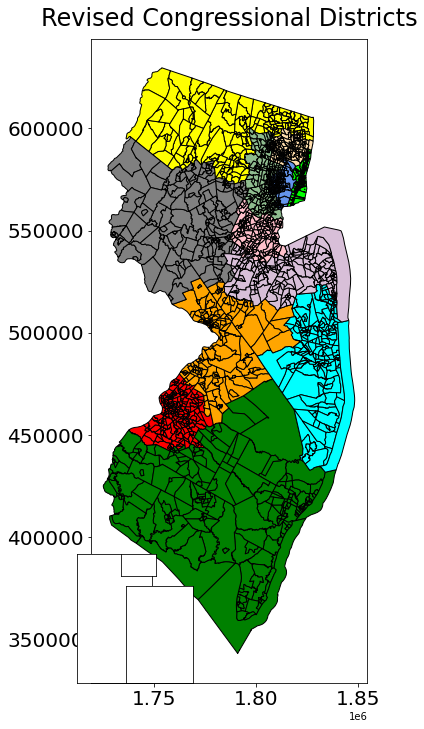

Done plotting and saving in 31 seconds!


In [18]:
s = time.time()
main_map_crs = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs "

alaska_crs = "epsg:3338"
hawaii_crs = "+proj=tmerc +lat_0=21.16666666666667 +lon_0=-158 +k=0.99999 +x_0=500000.0000000002 +y_0=0 +datum=NAD83 +units=us-ft +no_defs "


show_tracts = False
show_water = False

print('main map...')

print('\treprojecting...')

main_map_bounds = unary_union(state_gdf[state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).geometry.tolist()).bounds
main_map_aspect_ratio = (main_map_bounds[2] - main_map_bounds[0]) / (main_map_bounds[3] - main_map_bounds[1])

fig, ax = plt.subplots(1,1,figsize=(24, 24/main_map_aspect_ratio))
ax.set_aspect('equal')


print('\tplotting...')

for this_state in state_gdf[(state_gdf['STUSPS'].isin(these_states_dict.keys())) & (state_gdf['STUSPS'].apply(lambda x: x not in ['AK', 'HI']))]['STUSPS'].sort_values().tolist():
    print('\t\tPlotting {0:}...'.format(this_state))
    new_district_list = tract_gdf[(tract_gdf['STUSAB'] == this_state)]['new_district'].drop_duplicates().sort_values().tolist()
    for i in range(1, len(new_district_list)+1):
        tract_gdf[
            (tract_gdf['STUSAB'] == this_state) 
            & (tract_gdf['new_district'] == i)
        ].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black')
    

if (show_tracts):
    print('\tplotting census tracts...')
    tract_gdf[tract_gdf['STATEFP'].apply(lambda x: x not in [2,15])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

if (show_water):
    print('\tplotting census tracts...')
    water_gdf[water_gdf['STUSAB'].apply(lambda x: x not in ['AK','HI'])].to_crs(main_map_crs).plot(ax=ax, color='blue', edgecolor='none', linewidth=0.5)



    
#ax.legend(handles=legend_list, fontsize=10)

ax.set_title('Revised Congressional Districts', fontsize=24, y=1.01)

ax.tick_params(axis='both', labelsize=20)

# # # # # # print('saving figure...')
# # # # # # fig.savefig('{0:}{1:}_old.png'.format(script_dir, list(these_states_dict.keys())[0].lower()), format='png', dpi=300, bbox_inches='tight', facecolor='white')

# # # # #plt.show()
# # # e = time.time()
# # # g += (e-s)
# # # print('Done plotting in {0:.0f} minutes {1:.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
# # # #[inset['axes_position'][0], inset['axes_position'][1], inset['axes_size'][0], inset['axes_size'][1]]

# # # state_gdf[state_gdf['NAME'].apply(lambda x: x not in ['Alaska', 'Hawaii'])].to_crs(main_map_crs).plot(ax=ax)

print('AK inset...')
print('\treprojecting Alaska...')
ak_map_bounds = geopandas.GeoDataFrame(data=[[unary_union(county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAMELSAD'].apply(lambda x: 'aleutians west' not in x.lower()))].geometry.tolist())]], columns=['geometry'], crs=county_gdf.crs, geometry='geometry').to_crs(alaska_crs).bounds.values[0].tolist()
ak_map_aspect_ratio = (ak_map_bounds[2] - ak_map_bounds[0]) / (ak_map_bounds[3] - ak_map_bounds[1])

ak_inset_ax = ax.inset_axes([-0.049,0,ak_map_aspect_ratio*0.2,0.2])

#ak_inset_ax = ax.inset_axes([0,0,ak_map_aspect_ratio*1,1])

print('\t\treprojecting Aleutians West...')
aleutians_west_map_bounds = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Aleutians West')
].to_crs(alaska_crs).geometry.tolist()).bounds

aleutians_west_map_aspect_ratio = (aleutians_west_map_bounds[2] - aleutians_west_map_bounds[0]) / (aleutians_west_map_bounds[3] - aleutians_west_map_bounds[1])

# aleutians_inset_ax = ak_inset_ax.inset_axes([-0.325,-0.015,0.2*aleutians_west_map_aspect_ratio,0.2])   # to show Aletuians West in their actual geographic spot
aleutians_inset_ax = ak_inset_ax.inset_axes([0.59,0.825,0.175*aleutians_west_map_aspect_ratio,0.175])

print('plotting Alaska...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'AK')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(new_district_list)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=ak_inset_ax, color=district_color_cycle[i], edgecolor='black')
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'AK') & (tract_gdf['new_district'] == i)], 
        county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] == 'Aleutians West')],
        how='intersection').to_crs(alaska_crs).plot(ax=aleutians_inset_ax, color=district_color_cycle[i], edgecolor='black')
# if (show_tracts):
#     print('\tplotting census tracts...')
#     tract_gdf[tract_gdf['STUSAB'].apply(lambda x: x not in ['AK', 'HI'])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)
    

print('HI inset...')
print('\treprojecting and plotting Hawaii...')
print('\t\tremoving outer islands...')
honolulu_county_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] == 'Honolulu')
].geometry.tolist())
honolulu_county_bounds = honolulu_county_geo.bounds
fixed_honolulu_county_geo = unary_union(geopandas.overlay(
    geopandas.GeoDataFrame(data=[[honolulu_county_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'), 
    geopandas.GeoDataFrame(data=[[box(-160, honolulu_county_bounds[1], honolulu_county_bounds[2], honolulu_county_bounds[3])]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry'),
    how='intersection'
).geometry.tolist())
other_hawaii_geo = unary_union(county_gdf[
    (county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Hawaii')]['STATEFP'].values[0])
    & (county_gdf['NAME'] != 'Honolulu')
].geometry.tolist())
fixed_hawaii_geo = unary_union([other_hawaii_geo, fixed_honolulu_county_geo])
fixed_hawaii_gdf = geopandas.GeoDataFrame(data=[[fixed_hawaii_geo]], columns=['geometry'], crs=state_gdf.crs, geometry='geometry')

hi_map_bounds = fixed_hawaii_gdf.geometry.to_crs(hawaii_crs).geometry.apply(lambda x: x.bounds).values[0]
hi_map_aspect_ratio = (hi_map_bounds[2] - hi_map_bounds[0]) / (hi_map_bounds[3] - hi_map_bounds[1])

#print(hi_map_aspect_ratio)

hi_inset_ax = ax.inset_axes([0.128,0,hi_map_aspect_ratio*0.15,0.15])

print('plotting Hawaii...')
new_district_list = tract_gdf[(tract_gdf['STUSAB'] == 'HI')]['new_district'].drop_duplicates().sort_values().tolist()
for i in range(1, len(cdlist)+1):
    geopandas.overlay(
        tract_gdf[(tract_gdf['STUSAB'] == 'HI') & (tract_gdf['new_district'] == i)], 
        fixed_hawaii_gdf,
        #county_gdf[(county_gdf['STATEFP'] == state_gdf[(state_gdf['NAME'] == 'Alaska')]['STATEFP'].values[0]) & (county_gdf['NAME'] != 'Aleutians West')],
        how='intersection').to_crs(hawaii_crs).plot(ax=hi_inset_ax, color=district_color_cycle[i], edgecolor='black')

### Check RI
# ax.set_xlim([1.9e6, 2.2e6])
# ax.set_ylim([.7e6, .9e6])

for thisax in [ak_inset_ax, aleutians_inset_ax, hi_inset_ax]: #[ax, ak_inset_ax, aleutians_inset_ax, hi_inset_ax]:
    thisax.set_xticks([])
    thisax.set_yticks([])

plt.show()
# print('saving figure...')
# fig.savefig(script_dir+'new-districts-11.jpg', format='jpg', dpi=300, bbox_inches='tight')
e = time.time()
g += (e-s)
print('Done plotting and saving in {0:,.0f} seconds!'.format(e-s))


In [19]:
s = time.time()
tract_gdf['new_district'].to_csv(script_dir+'new-districts-12.csv')
e = time.time()
g += (e-s)
print('Classified and saved {0:,.0f} in {1:,.0f} minutes {2:,.0f} seconds!'.format(len(tract_gdf), np.floor((e-s)/60), (e-s)%60))
print('\n')
print('TOTAL TIME: {0:,.0f} minutes {1:,.0f} seconds!'.format( np.floor(g/60), g%60))

Classified and saved 2,181 in 0 minutes 0 seconds!


TOTAL TIME: 2 minutes 54 seconds!


# NEW JERSEY

In [20]:
# s = time.time()
# this_state = 'NJ'

# show_water = False
# label_tracts = False

# show_counties = False
# label_counties = False
# show_cbsa = False
# label_cbsa = False

# show_places = False
# label_places = False

# print_ready = False
# assign_to_district = 1

# the_label_size = 20
# the_annotation_size = 18
# the_annotation_size_big = 28
# the_line_width = .5
# the_line_width_medium = 2
# the_line_width_wide = 4
# the_legend_size = 18
# the_title_size = 28

# bounds_counties = []

# if (len(bounds_counties) > 0):
#     xlimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).geometry.tolist()).bounds[3]]
# else:
#     xlimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[0], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[2]]
#     ylimits = [unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[1], unary_union(state_gdf[(state_gdf['STUSPS'] == this_state)].to_crs(main_map_crs).geometry.tolist()).bounds[3]]




# xspan = xlimits[1] - xlimits[0]
# yspan = ylimits[1] - ylimits[0]
# aspect_ratio = xspan / yspan

# xbuffer = xspan * map_buffer_ratio
# ybuffer = yspan * map_buffer_ratio

# xlimits = [xlimits[0] - xbuffer, xlimits[1] + xbuffer] #cd_gdf.geometry.apply(lambda x: (x.bounds[0] - xbuffer, x.bounds[2] + xbuffer)).values[0]
# ylimits = [ylimits[0] - ybuffer, ylimits[1] + ybuffer] 

# print('xspan = {0:,.2f} km'.format(xspan / 1000))
# print('yspan = {0:,.2f} km'.format(yspan / 1000))
# print('aspect_ratio  = {0:,.2f}:1'.format(aspect_ratio))
# print('\n')


# # fig, ax = plt.subplots(1,1, figsize=(xspan*scale, yspan*scale))
# fig, ax = plt.subplots(1,1,figsize=(24, 24/aspect_ratio))
# ax.set_aspect('equal')

# print('plotting tracts...')
# # base layer
# legend_list = []
# for i in range(-1,these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         print(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum())
#         tract_gdf[(tract_gdf['new_district'] == i)].to_crs(main_map_crs).plot(ax=ax, color=district_color_cycle[i], edgecolor='black', linewidth=the_line_width)#, alpha=0.25)
#         legend_list.append(mpatches.Patch(color=district_color_cycle[i], label='District {0:,.0f}'.format(i)))

# tract_gdf[(tract_gdf['new_district'].isnull())].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', lw=the_line_width)


# if (show_places):
#     print('plotting places...')
#     place_gdf.to_crs(main_map_crs).plot(ax=ax, edgecolor='green', lw=the_line_width_medium, color='none')
    
# if (label_places):
#     print('\tlabeling places...')
#     for ix, thisrow in geopandas.overlay(
#         place_gdf.reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (thisrow['NAME'] not in []):
#                 annotator = thisrow['NAME'].replace(' ', '\n')
#                 centerpoint = thisrow.geometry.centroid.coords[0]
#                 ax.annotate(annotator, centerpoint, color='red', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))

# if (show_water):
#     print('plotting water areas...')
#     water_gdf.to_crs(main_map_crs).plot(ax=ax, color='blue')#, alpha=0.5)

# if (show_counties):
#     print('plotting state and county borders...')
#     if (len(bounds_counties) > 0):   
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) & (county_gdf['NAME'].isin(bounds_counties))].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     else:
#         county_gdf[(county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0])].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width_wide)
#     state_gdf[state_gdf['STUSPS'] == this_state].to_crs(main_map_crs).plot(ax=ax, color='none', edgecolor='black', linewidth=the_line_width, zorder=99)

# if (label_counties):
#     print('labeling counties...')
#     if (len(bounds_counties) > 0):
#         counties_to_label = bounds_counties
#     else:
#         counties_to_label = county_gdf[county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]]['NAME'].tolist()
#     for ix, thisrow in county_gdf[
#         (county_gdf['STATEFP'] == state_codes_df[state_codes_df['STUSAB'] == this_state]['STATE'].values[0]) 
#         & (county_gdf['NAME'].isin(counties_to_label))
# #         & ( 
# #             ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.x) <= xlimits[1]))
# #             & ((county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) >= xlimits[0]) & (county_gdf.to_crs(main_map_crs).geometry.apply(lambda x: x.centroid.y) <= xlimits[1]))
# #         )        
#     ].to_crs(main_map_crs).iterrows():
#         ax.annotate('{0:}'.format(thisrow['NAME'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='black', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size_big)


# if (show_cbsa):
#     print('plotting CBSAs...')
#     cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x[x.find(',')+2:])].to_crs(main_map_crs).plot(ax=ax, edgecolor='red', lw=the_line_width_wide, color='none')

# if (label_cbsa):
#     for ix, thisrow in geopandas.overlay(cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: this_state in x[x.find(',')+2:])].reset_index().rename(columns={'NAME': 'cbsa_name'}), state_gdf[state_gdf['STUSPS'] == this_state][['STUSPS', 'geometry']], how='intersection').set_index('GEOID').to_crs(main_map_crs).iterrows():
#         print(thisrow['cbsa_name'])
#         labelpoint = thisrow.geometry.centroid.coords[0]
#         ax.annotate('{0:}'.format(thisrow['cbsa_name'].replace(' ','\n')), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), color='red', backgroundcolor='white', ha='center', va='center',  fontsize=the_annotation_size_big)
        
# if (label_tracts):
#     print('\tlabeling tracts...')
#     if (print_ready):
#         print('\n')
#         print("tract_gdf.loc[[")
#     for ix, thisrow in geopandas.overlay(
#         tract_gdf[
#             #(tract_gdf['new_district'].isnull())
#             (tract_gdf['new_district'] == 1)
#         ].reset_index().to_crs(main_map_crs),
#         geopandas.GeoDataFrame(data=[[box(xlimits[0], ylimits[0], xlimits[1], ylimits[1])]], columns=['geometry'], crs=main_map_crs, geometry='geometry'),
#         how='intersection').set_index('GEOID').iterrows():
#             if (print_ready):
#                 print("\t'{0:}', ".format(ix))
#             else:
#                 print('\t{0:}-{1:}: {2:}'.format(thisrow['COUNTY_NAME'][0:3], thisrow['census_tract'], ix))
#             annotator = '{0:}\n({1:,.0f})'.format(thisrow['census_tract'], thisrow['POP100'])
#             centerpoint = thisrow.geometry.centroid.coords[0]
#             ax.annotate(annotator, centerpoint, color='black', ha='center', va='center', fontsize=the_annotation_size, bbox=dict(facecolor='white', edgecolor='black', pad=4))
#     if (print_ready):
#         print("], 'new_district'] = {0:.0f}".format(assign_to_district))
        
# plt.xlim(xlimits)
# plt.ylim(ylimits)

# ax.tick_params(axis='both', labelsize=20, labelbottom=True, labeltop=True, labelleft=True, labelright=True)

# # nticks = 10
# # ax.set_xticks(np.arange(xlimits[0], xlimits[1], (xlimits[1]-xlimits[0])/nticks))
# # ax.xaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.set_yticks(np.arange(ylimits[0], ylimits[1], (ylimits[1]-ylimits[0])/nticks))
# # ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# # ax.xaxis.set_tick_params(labelbottom=True, labeltop=True, labelsize=the_label_size, length=10, width=4, left=True, right=True)
# # ax.yaxis.set_tick_params(labelleft=True, labelright=True, labelsize=the_label_size, length=10, width=4, top=True, bottom=True)

# #ax.legend(handles=legend_list, fontsize=the_legend_size, loc='lower left')



# if (len(list(these_states_dict.keys())) == 1):
#     plt.title('New {0:} Congressional Districts (n = {1:.0f})'.format(
#         list(these_states_dict.keys())[0], 
#         these_states_dict[list(these_states_dict.keys())[0]]['seats_new']
#     ), fontsize=the_title_size)
# else:    
#     plt.title('New Congressional Districts', fontsize=the_title_size)

# print('\n')    
# for i in range(1, these_states_dict[this_state]['seats_new']+1):
#     if (tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() > 0):
#         #if (np.abs(1-(tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target)) > 0.01):
#         print('District {0:}: n = {1:,.0f} ({2:.1%} of target; overshot = {3:,.0f})'.format(i, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum(), tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum()/state_target, tract_gdf[tract_gdf['new_district'] == i]['POP100'].sum() - state_target))

# e = time.time()
# g += (e-s)

# print('Plotted in {0:,.0f} minutes {1:,.0f} seconds!'.format(np.floor((e-s)/60), (e-s)%60))
        
# plt.show()




In [21]:




# NAME	POP100
# GEOID		
# 35620	New York-Newark-Jersey City, NY-NJ-PA	6915597.0
# 37980	Philadelphia-Camden-Wilmington, PA-NJ-DE-MD	1352476.0
# 45940	Trenton-Princeton, NJ	387340.0
# 12100	Atlantic City-Hammonton, NJ	274534.0
# 47220	Vineland-Bridgeton, NJ	154152.0
# 10900	Allentown-Bethlehem-Easton, PA-NJ	109632.0
# 36140	Ocean City, NJ	95263.0

In [22]:
######## NEW JERSEY ##########

##### West of Newark    
# xlimits = [1.806e6,1.812e6]
# ylimits = [562000,577500]

# ##### West of North Arlington
# xlimits = [1.807e6,1.813e6]
# ylimits = [576000,583000]

### Between Elizabeth and Summit
# xlimits = [1.798e6,1.811e6]
# ylimits = [557500,567500]

### North-central Morris County
# xlimits = [1.755e6,1.785e6]
# ylimits = [573000,585000]


### North-central Middlesex County
# xlimits = [1.79e6,1.81e6]
# ylimits = [545000,552000]


### Northern Monmouth County
# xlimits = [1.81e6,1.84e6]
# ylimits = [527000,548000]


#### Freehold
# xlimits = [1.804e6,1.820e6]
# ylimits = [510000,525000]


### South coast of Monmouth County
# xlimits = [1.825e6,1.84e6]
# ylimits = [512000,524000]


# #### Philly suburbs
# xlimits = [1.753e6, 1.776e6]
# ylimits = [448000, 476000]


# #### Philly suburbs (narrower)
# xlimits = [1.755e6, 1.772e6]
# ylimits = [460000, 474000]


# #### Philly suburbs (medium)
# xlimits = [1.755e6, 1.775e6]
# ylimits = [452000, 482000]
